# Topic Modeling

### import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk, re
import textblob
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation , NMF

import warnings
warnings.filterwarnings("ignore")

### Read data

In [2]:
data = pd.read_csv("articles1.csv", usecols=['content'])

In [3]:
X = data[['content']]
X.head()

,content
0,WASHINGTON — Congressional Republicans have...
1,"After the bullet shells get counted, the blood..."
2,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,"Death may be the great equalizer, but it isn’t..."
4,"SEOUL, South Korea — North Korea’s leader, ..."


In [4]:
class TextPreprocessor:

    def text_cleaning(text: str) -> str:
        """
        args: text (str)
        return: str
        This function cleans the text from the links, tweet mentions, usernames etc..
        """
        text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
        return re.sub(text_cleaning_re, " ", text.lower()).strip()
    
    def remove_stopwords(text: str) -> str:
        """
        Removes the stopwords from the text.
        """
        STOP_WORDS = stopwords.words('english')
        return ' '.join([word for word in text.split() if word not in STOP_WORDS])

    def stemming(text: str) -> str:
        """
        Stems the text.
        """
        stemmer = SnowballStemmer("english")
        return ' '.join([stemmer.stem(word) for word in text.split()])

    def lemmatization(text: str) -> str:
        """
        Lemmatization is the process of grouping together the inflected forms of a word.
        Parameters:
            text: str
        """
        lemmatizer = WordNetLemmatizer()
        return ' '.join([lemmatizer.lemmatize(word, 'v') for word in text.split()])


    def preprocess_text(text: str, stem=True) -> str:
        """
        Preprocesses the text.
        Parameters:
            text: the text to preprocess.
            stem: if True, stems the text.
            else, lemmatizes the text.
        """
        if stem:
            return TextPreprocessor.stemming(TextPreprocessor.remove_stopwords(TextPreprocessor.text_cleaning(text)))
        else:
            return TextPreprocessor.lemmatization(TextPreprocessor.remove_stopwords(TextPreprocessor.text_cleaning(text)))

In [5]:
class Preprocessing:   
    def __init__(self):
        """
        Initializes the preprocessing class.
        """
        self.path = "articles1.csv"
        self.df = self.load_data()

    def load_data(self):
        """
        Loads the data.
        """
        return pd.read_csv(self.path, usecols=['content'])

    def preprocesss(self):
        """
        Preprocesses the data.
        Apply preprocess_text from TextProcessor class on the "content" column.
        """
        self.df['cleaned'] = self.df['content'].apply(TextPreprocessor.preprocess_text, args=(False,)) #stem = False
        self.corpus = self.df['cleaned'].to_numpy()
        self.corpus_train, self.corpus_test = train_test_split(self.corpus, train_size=0.8, shuffle=True, random_state=42)
        print("Done preprocessing.")

    def CountVec(self):
        """
        CountVectorizer simply counts the number of times a word appears in a document (using a bag-of-words approach)
        """
        self.countvectorizer = CountVectorizer()
        self.X_train = self.countvectorizer.fit_transform(self.corpus_train)
        self.X_test = self.countvectorizer.transform(self.corpus_test)
        print("Done BoW.")
    
    def getCountVec(self):
        return self.countvectorizer
    
    def TFIDF(self):
        """
        while TF-IDF Vectorizer takes into account not only how many times a word appears in a document 
        but also how important that word is to the whole corpus.
        """
        self.tfidf = TfidfVectorizer()
        self.X_train = self.tfidf.fit_transform(self.corpus_train)
        self.X_test = self.tfidf.transform(self.corpus_test)
        print("Done TF-IDF.")
    
    def getTFIDF(self):
        return self.tfidf
    
    
    def __call__(self, *args):
        """
        First apply preprocesss function.
        Then check if args = true apply CountVec else apply TF-IDF.
        """
        print("Passed arguements: ", args)
        if(len(args) > 1):
            raise ValueError("No more than one argument")
        self.preprocesss()
        if args[0]:
            self.CountVec()
        else:
            self.TFIDF()
   

    def getXs(self):
        return self.X_train, self.X_test

In [6]:
pp = Preprocessing()
pp(False)
X_train_tfidf, X_test_tfidf = pp.getXs()

Passed arguements:  (False,)
Done preprocessing.
Done TF-IDF.


In [7]:
pp2 = Preprocessing()
pp2(True)
X_train_cv, X_test_cv = pp2.getXs()

Passed arguements:  (True,)
Done preprocessing.
Done BoW.


## Model training and testing

In [8]:
# Train and test the TF-IDF model
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=42)
lda_tfidf.fit(X_train_tfidf)



LatentDirichletAllocation(n_components=5, random_state=42)

In [9]:
# Train and test the BoW model
lda_cv = LatentDirichletAllocation(n_components=5, random_state=42)
lda_cv.fit(X_train_cv)

LatentDirichletAllocation(n_components=5, random_state=42)

In [10]:
perplexity_tfidf = lda_tfidf.perplexity(X_test_tfidf)

In [11]:
perplexity_cv = lda_cv.perplexity(X_test_cv)

In [12]:
# Print the perplexity of the trained models on the test data
print("Perplexity of the TF-IDF model on the test data: ", perplexity_tfidf)
print("Perplexity of the BoW model on the test data: ", perplexity_cv)

Perplexity of the TF-IDF model on the test data:  50027.21028920942
Perplexity of the BoW model on the test data:  4610.609989678566


In [13]:
# Print top words associated with each topic for the TF-IDF model
tfidf_feature_names = pp.getTFIDF().get_feature_names()
n_top_words = 10
print("Top words associated with each topic for the TF-IDF model:")
for topic_idx, topic in enumerate(lda_tfidf.components_):
    message = "Topic #%d: " % topic_idx
    message += " ".join([tfidf_feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Top words associated with each topic for the TF-IDF model:
Topic #0: trump say mr clinton state president people would go one
Topic #1: advertisement hastert malaysian germanwings lubitz cooperman kuala lumpur vetrano hidinghillary
Topic #2: olango dubose duggar sunedison bissonnette biosimilar graswald valueact montano zellweger
Topic #3: migrants cartel zika migrant le virus asylum french france macron
Topic #4: company apple tesla film uber google app music store amazon


In [14]:
# Print top words associated with each topic for the BoW model
cv_feature_names = pp2.getCountVec().get_feature_names()
n_top_words = 10
print("Top words associated with each topic for the BoW model:")
for topic_idx, topic in enumerate(lda_cv.components_):
    message = "Topic #%d: " % topic_idx
    message += " ".join([cv_feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Top words associated with each topic for the BoW model:
Topic #0: trump say clinton president mr campaign would state donald go
Topic #1: say people state us mr would unite world one country
Topic #2: say mr police state court case school one officer law
Topic #3: say state attack report police people kill one group two
Topic #4: say like one make go get time new people company


## visualize results

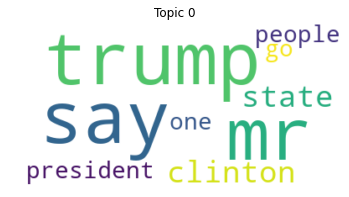

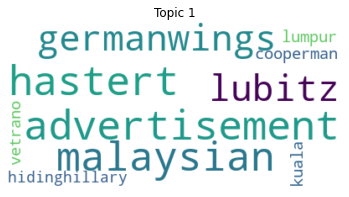

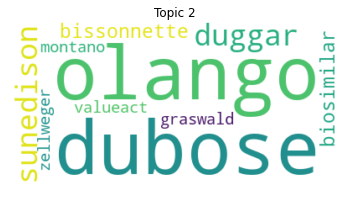

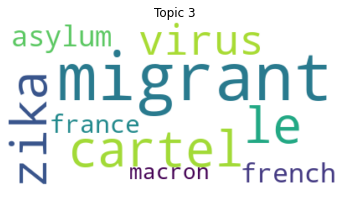

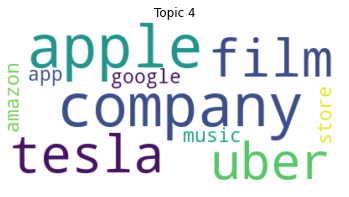

In [15]:
# Get the topic-word matrix for the TF-IDF model
tfidf_topic_word = lda_tfidf.components_ / lda_tfidf.components_.sum(axis=1)[:, np.newaxis]

# Create word clouds for the top words associated with each topic
n_top_words = 10
for topic_idx, topic in enumerate(tfidf_topic_word):
    top_words = [tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    wordcloud = WordCloud(background_color='white').generate(' '.join(top_words))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Topic ' + str(topic_idx))
    plt.show()

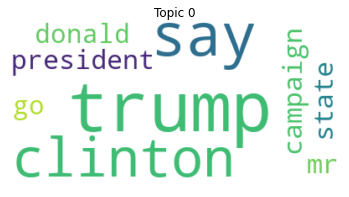

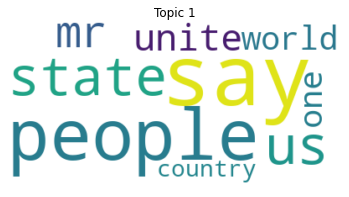

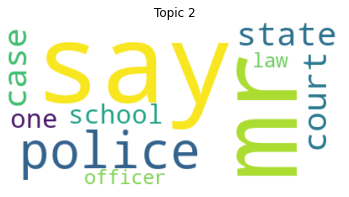

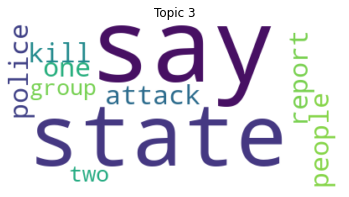

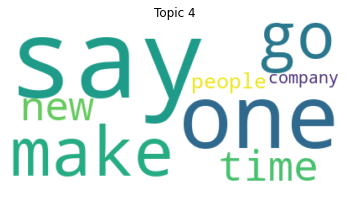

In [16]:
# Get the topic-word matrix for the BoW model
cv_topic_word = lda_cv.components_ / lda_cv.components_.sum(axis=1)[:, np.newaxis]

# Create word clouds for the top words associated with each topic
n_top_words = 10
for topic_idx, topic in enumerate(cv_topic_word):
    top_words = [cv_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    wordcloud = WordCloud(background_color='white').generate(' '.join(top_words))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Topic ' + str(topic_idx))
    plt.show()

## model training & testing

In [17]:
# Train and test the TF-IDF model
nmf_tfidf = NMF(n_components=5, random_state=42)
W_train_tfidf = nmf_tfidf.fit_transform(X_train_tfidf)
W_test_tfidf = nmf_tfidf.transform(X_test_tfidf)

In [18]:
# Train and test the BoW model
nmf_cv = NMF(n_components=5, random_state=42)
W_train_cv = nmf_cv.fit_transform(X_train_cv)
W_test_cv = nmf_cv.transform(X_test_cv)

In [19]:
nmf_perplexity_tfidf = nmf_tfidf.reconstruction_err_
nmf_perplexity_cv = nmf_cv.reconstruction_err_

In [20]:
# Print the perplexity of the trained models on the test data
print("Perplexity of the TF-IDF model on the test data: ", nmf_perplexity_tfidf)
print("Perplexity of the BoW model on the test data: ", nmf_perplexity_cv)

Perplexity of the TF-IDF model on the test data:  193.79439345916578
Perplexity of the BoW model on the test data:  6546.969201820203


In [22]:
# Print top words associated with each topic for the TF-IDF model
tfidf_feature_names = pp.getTFIDF().get_feature_names()
n_top_words = 10
print("Top words associated with each topic for the TF-IDF model:")
for topic_idx, topic in enumerate(nmf_tfidf.components_):
    message = "Topic #%d: " % topic_idx
    message += " ".join([tfidf_feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Top words associated with each topic for the TF-IDF model:
Topic #0: say police people one go get like time make new
Topic #1: trump donald republican president cruz say campaign vote house go
Topic #2: mr say mrs ms trump would campaign party unite senator
Topic #3: clinton hillary sanders email campaign democratic poll voters foundation state
Topic #4: russia state obama say president syria russian us isis attack


In [23]:
# Print top words associated with each topic for the BoW model
cv_feature_names = pp2.getCountVec().get_feature_names()
n_top_words = 10
print("Top words associated with each topic for the BoW model:")
for topic_idx, topic in enumerate(nmf_cv.components_):
    message = "Topic #%d: " % topic_idx
    message += " ".join([cv_feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Top words associated with each topic for the BoW model:
Topic #0: say people clinton ask go get sanders want tell like
Topic #1: trump 2016 clinton campaign donald cruz president rubio twitter hillary
Topic #2: mr say trump state ms would president new unite mrs
Topic #3: one would make go state time people new like get
Topic #4: police attack 2016 officer report isis say kill shoot state


## visualize results

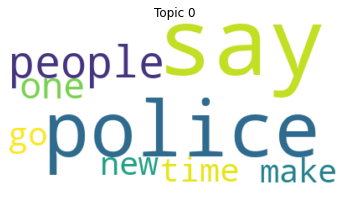

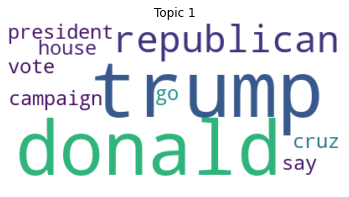

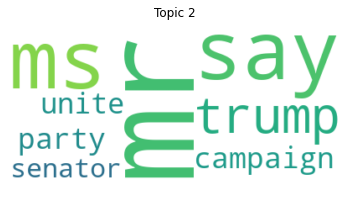

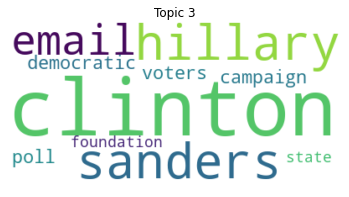

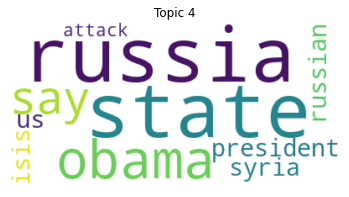

In [24]:
# Get the topic-word matrix for the TF-IDF model
tfidf_topic_word = nmf_tfidf.components_ / nmf_tfidf.components_.sum(axis=1)[:, np.newaxis]

# Create word clouds for the top words associated with each topic
n_top_words = 10
for topic_idx, topic in enumerate(tfidf_topic_word):
    top_words = [tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    wordcloud = WordCloud(background_color='white').generate(' '.join(top_words))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Topic ' + str(topic_idx))
    plt.show()

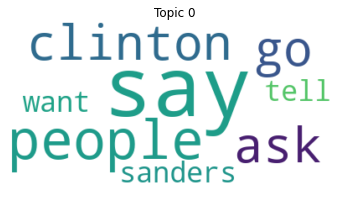

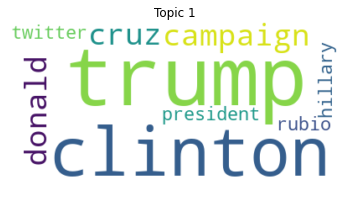

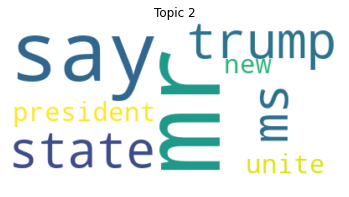

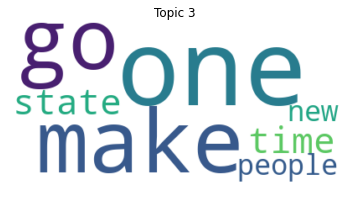

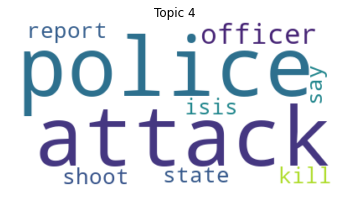

In [25]:
# Get the topic-word matrix for the BoW model
cv_topic_word = nmf_cv.components_ / nmf_cv.components_.sum(axis=1)[:, np.newaxis]

# Create word clouds for the top words associated with each topic
n_top_words = 10
for topic_idx, topic in enumerate(cv_topic_word):
    top_words = [cv_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    wordcloud = WordCloud(background_color='white').generate(' '.join(top_words))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Topic ' + str(topic_idx))
    plt.show()